In [1]:
import os, time, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DIR = "/content/drive/MyDrive/SKRIPSI/split/K/k5"

train_df = pd.read_csv(f"{DATA_DIR}/train_fold2.csv")
val_df   = pd.read_csv(f"{DATA_DIR}/val_fold2.csv")

print(train_df.shape, val_df.shape)

(5622, 2) (1406, 2)


In [5]:
print(train_df.columns)
# harus menampilkan text, label_id

Index(['text', 'label_id'], dtype='object')


In [6]:
MODEL_NAME = "indolem/indobertweet-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
train_df = train_df.rename(columns={"label_id": "labels"})
val_df   = val_df.rename(columns={"label_id": "labels"})

In [8]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset   = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format("torch", columns=["input_ids","attention_mask","labels"])
val_dataset.set_format("torch", columns=["input_ids","attention_mask","labels"])

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

Map:   0%|          | 0/1406 [00:00<?, ? examples/s]

In [9]:
print(train_dataset)

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5622
})


In [49]:
from transformers import AutoConfig, AutoModelForSequenceClassification
import torch.nn as nn

def build_model(dropout_rate):
    config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=6)
    config.hidden_dropout_prob = dropout_rate
    config.attention_probs_dropout_prob = dropout_rate

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        config=config
    )

    # kalau head punya dropout, set juga
    if hasattr(model, "classifier") and hasattr(model.classifier, "dropout"):
        model.classifier.dropout = nn.Dropout(dropout_rate)

    return model

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1
    }


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

pink_cmap = LinearSegmentedColormap.from_list(
    "soft_pink_dark",
    ["#FCE4EC", "#F8BBD0", "#EC407A"]
)

def plot_confusion_matrix(
    y_true,
    y_pred,
    title,
    out_path=None
):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(cm, interpolation="nearest", cmap=pink_cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    n = cm.shape[0]
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels([str(i) for i in range(n)])
    ax.set_yticklabels([str(i) for i in range(n)])

    # 🔥 Threshold untuk kontras
    thresh = cm.max() * 0.6

    for i in range(n):
        for j in range(n):
            value = cm[i, j]

            ax.text(
                j, i,
                f"{value}",
                ha="center",
                va="center",
                color="white" if value > thresh else "#C2185B",  # pink gelap
                fontsize=10,
                fontweight="bold"
            )

    plt.tight_layout()

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=300)

    plt.show()

In [30]:
import os
import matplotlib.pyplot as plt

def plot_train_vs_val_loss(log_df, title="Loss Curve", out_path=None):

    train_df = log_df[log_df["loss"].notna()].copy()
    train_df = train_df.groupby("epoch").last().reset_index()

    val_df = log_df[log_df["eval_loss"].notna()].copy()
    val_df = val_df.groupby("epoch").last().reset_index()

    train_color = pink_cmap(0.3)
    val_color   = pink_cmap(0.85)

    fig, ax = plt.subplots(figsize=(7,5))

    ax.plot(
        train_df["epoch"],
        train_df["loss"],
        label="Train Loss",
        color=train_color,
        linewidth=2
    )

    ax.plot(
        val_df["epoch"],
        val_df["eval_loss"],
        label="Val Loss",
        color=val_color,
        linewidth=2
    )

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()

    # 🔥 BUAT FOLDER DULU
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.savefig(out_path, dpi=300, bbox_inches="tight")  # pakai fig.savefig


# Confusion Matrix

In [36]:
import os
import json
import pandas as pd

def get_log_df(run_dir):
    state_path = os.path.join(run_dir, "trainer_state.json")

    if not os.path.exists(state_path):
        raise FileNotFoundError(f"trainer_state.json not found in {run_dir}")

    with open(state_path, "r") as f:
        state = json.load(f)

    log_history = state["log_history"]
    log_df = pd.DataFrame(log_history)

    return log_df

In [37]:
import os
import matplotlib.pyplot as plt

def plot_train_vs_val_loss(log_df, title="Loss Curve", out_path=None):

    # Ambil train loss per epoch
    train_df = log_df[log_df["loss"].notna()].copy()
    train_df = train_df.groupby("epoch").last().reset_index()

    # Ambil val loss per epoch
    val_df = log_df[log_df["eval_loss"].notna()].copy()
    val_df = val_df.groupby("epoch").last().reset_index()

    # 💗 Ambil warna dari pink_map
    train_color = pink_cmap(0.3)   # pink muda
    val_color   = pink_cmap(0.85)  # pink tua

    plt.figure(figsize=(7,5))

    plt.plot(
        train_df["epoch"],
        train_df["loss"],
        label="Train Loss",
        color=train_color,
        linewidth=2
    )

    plt.plot(
        val_df["epoch"],
        val_df["eval_loss"],
        label="Val Loss",
        color=val_color,
        linewidth=2
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=300)

    plt.show()

In [38]:
PLOT_OUT_DIR = "/content/drive/MyDrive/SKRIPSI/plots"

In [39]:
import os
import pandas as pd
import numpy as np

# tetap (karena k=5 fold2 sama terus)
model_name  = "IndoBERTweet"
split_type  = "kfold"
scheme_name = "k5"
fold_name   = "fold2"

def make_tag(dropout):
    return f"{model_name} | {split_type} | {scheme_name} | {fold_name} | DO_{str(dropout).replace('.','_')}"

def make_path(prefix, dropout):
    fname = (
        f"{prefix}__{model_name}__{split_type}__{scheme_name}__{fold_name}"
        f"__DO_{str(dropout).replace('.','_')}.png"
    )
    return os.path.join(PLOT_OUT_DIR, fname)

In [32]:
import os

PLOT_OUT_DIR = "/content/drive/MyDrive/SKRIPSI/plots"
os.makedirs(PLOT_OUT_DIR, exist_ok=True)

print("PLOT_OUT_DIR:", PLOT_OUT_DIR)
print("Exists?", os.path.exists(PLOT_OUT_DIR))


PLOT_OUT_DIR: /content/drive/MyDrive/SKRIPSI/plots
Exists? True


In [45]:
results = []


===== TRAINING DROPOUT 0.3 =====


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: indolem/indobertweet-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,1.463648,0.833393,0.721195,0.734975,0.724274,0.724010
2,0.896038,0.674014,0.767425,0.764577,0.789267,0.773310
3,0.739908,0.642766,0.779516,0.778185,0.804899,0.788008
4,0.677777,0.648656,0.780228,0.777551,0.807779,0.787816
5,0.639552,0.656968,0.778805,0.773504,0.807487,0.785227


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved deploy-ready model to: /content/drive/MyDrive/SKRIPSI/model-fix/IndoBERTweet__k5__fold2__DO_0_3


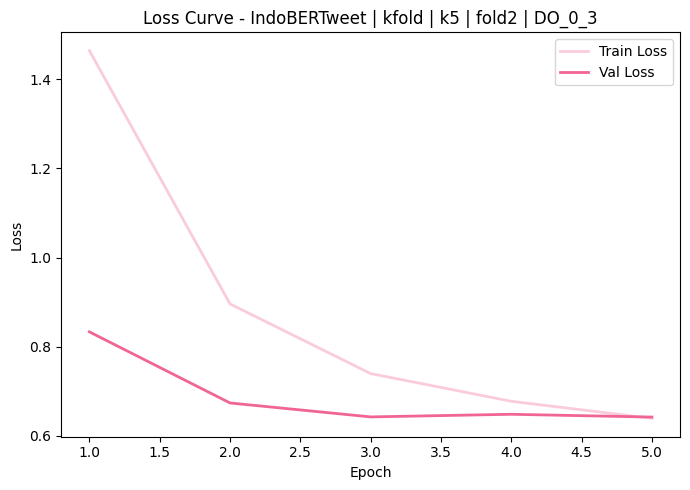

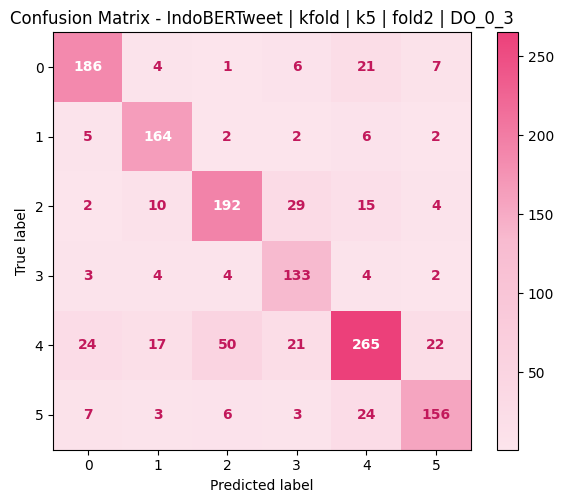

Saved plots to: /content/drive/MyDrive/SKRIPSI/plots/LOSS__IndoBERTweet__k5__fold2__DO_0_3.png and /content/drive/MyDrive/SKRIPSI/plots/CM__IndoBERTweet__k5__fold2__DO_0_3.png

===== TRAINING DROPOUT 0.5 =====


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: indolem/indobertweet-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,1.775223,1.717260,0.288762,0.179320,0.172709,0.087816
2,1.762203,1.710555,0.285206,0.145862,0.177965,0.110422
3,1.757490,1.695985,0.290896,0.143395,0.177746,0.101223
4,1.755609,1.689590,0.296586,0.150969,0.185627,0.115738
5,1.748892,1.692198,0.291607,0.146230,0.178651,0.102966
6,1.748151,1.684386,0.305832,0.150570,0.198208,0.129581
7,1.750277,1.674875,0.313656,0.191660,0.208804,0.141539
8,1.744183,1.679350,0.314367,0.182629,0.212400,0.138695
9,1.740904,1.674904,0.318634,0.191498,0.212872,0.139972


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved deploy-ready model to: /content/drive/MyDrive/SKRIPSI/model-fix/IndoBERTweet__k5__fold2__DO_0_5


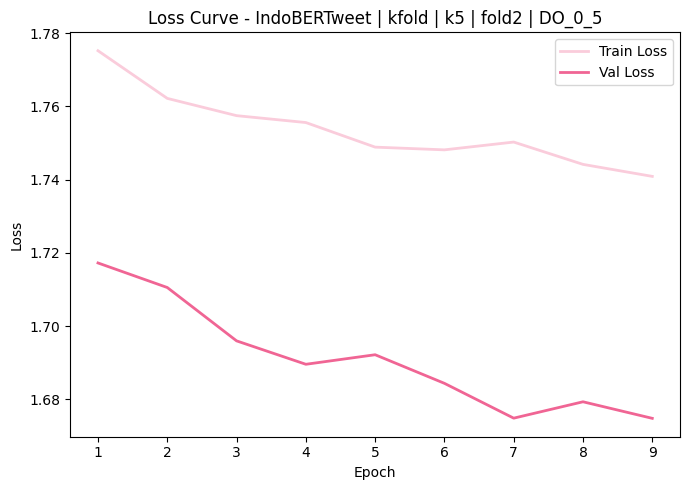

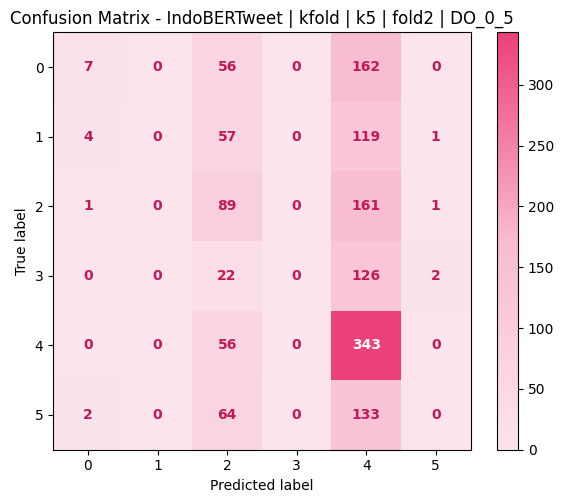

Saved plots to: /content/drive/MyDrive/SKRIPSI/plots/LOSS__IndoBERTweet__k5__fold2__DO_0_5.png and /content/drive/MyDrive/SKRIPSI/plots/CM__IndoBERTweet__k5__fold2__DO_0_5.png

===== TRAINING DROPOUT 0.75 =====


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: indolem/indobertweet-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,1.837320,1.817246,0.283784,0.047297,0.166667,0.073684
2,1.818146,1.834636,0.283784,0.047297,0.166667,0.073684
3,1.813343,1.842486,0.283784,0.047297,0.166667,0.073684


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved deploy-ready model to: /content/drive/MyDrive/SKRIPSI/model-fix/IndoBERTweet__k5__fold2__DO_0_75


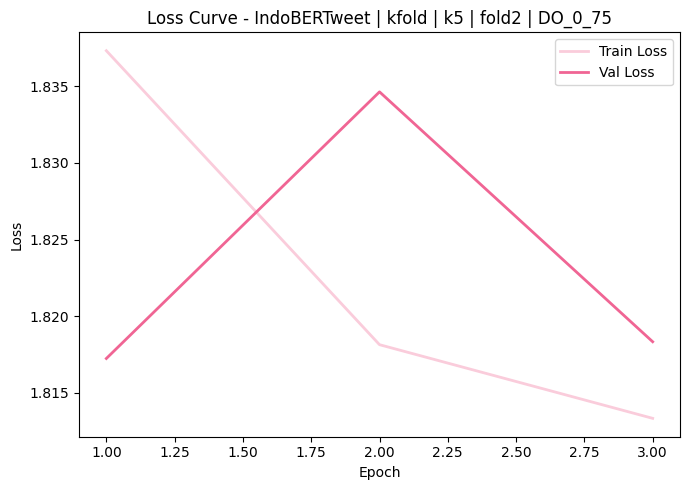

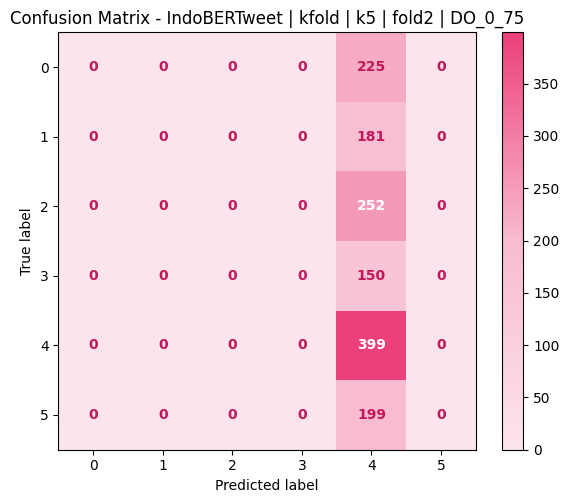

Saved plots to: /content/drive/MyDrive/SKRIPSI/plots/LOSS__IndoBERTweet__k5__fold2__DO_0_75.png and /content/drive/MyDrive/SKRIPSI/plots/CM__IndoBERTweet__k5__fold2__DO_0_75.png
CSV metrics saved to: /content/drive/MyDrive/SKRIPSI/model-fix/METRICS__IndoBERTweet__k5__fold2__dropout_compare.csv


,dropout,accuracy,precision_macro,recall_macro,f1_macro,eval_loss,train_time_sec
0,0.30,0.779516,0.778185,0.804899,0.788008,0.642391,137.84
1,0.50,0.312233,0.181211,0.207322,0.138772,1.674827,248.74
2,0.75,0.283784,0.047297,0.166667,0.073684,1.818338,83.28


In [52]:
dropout_list = [0.3, 0.5, 0.75]

import shutil
# ===== pastikan sama persis seperti notebook lama =====
LR = 2e-5
WEIGHT_DECAY = 0.01
EPOCHS = 20
BATCH_SIZE = 16
EARLY_PATIENCE = 2
EARLY_THRESHOLD = 0.0
MAX_LEN = 128
SEED = 42
SAVE_ROOT = "/content/drive/MyDrive/SKRIPSI/model-fix/"

dropout_list = [0.3, 0.5, 0.75]

os.makedirs(SAVE_ROOT, exist_ok=True)
os.makedirs(PLOT_OUT_DIR, exist_ok=True)

results = []

for dr in dropout_list:

    # ===== folder deploy final di Drive =====
    out_dir = os.path.join(SAVE_ROOT, f"IndoBERTweet__k5__fold2__DO_{str(dr).replace('.','_')}")
    os.makedirs(out_dir, exist_ok=True)

    print(f"\n===== TRAINING DROPOUT {dr} =====")

    model = build_model(dr)

    # ===== folder checkpoint trainer (lokal runtime) =====
    trainer_out = f"./tmp_indobertweet_DO_{str(dr).replace('.','_')}"

    # ===== hapus dulu biar gak resume checkpoint lama =====
    if os.path.exists(trainer_out):
        shutil.rmtree(trainer_out)

    training_args = TrainingArguments(
        output_dir=trainer_out,
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=WEIGHT_DECAY,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,   # <= sesuai request
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_strategy="epoch",
        fp16=torch.cuda.is_available(),
        report_to="none",
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(
            early_stopping_patience=EARLY_PATIENCE,
            early_stopping_threshold=EARLY_THRESHOLD
        )]
    )

    t0 = time.time()
    trainer.train()
    t1 = time.time()

    eval_result = trainer.evaluate()

    row = {
      "dropout": dr,
      "accuracy": eval_result.get("eval_accuracy"),
      "precision_macro": eval_result.get("eval_precision_macro"),
      "recall_macro": eval_result.get("eval_recall_macro"),
      "f1_macro": eval_result.get("eval_f1_macro"),
      "eval_loss": eval_result.get("eval_loss"),
      "train_time_sec": round(t1 - t0, 2)
    }
    results.append(row)


    # ===== SIMPAN MODEL DEPLOY KE DRIVE =====
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)

    summary = {
        "dropout_rate": dr,
        "train_time_sec": round(t1 - t0, 2),
        "eval_metrics": {k: float(v) for k, v in eval_result.items()},
        "hyperparams": {
            "max_len": MAX_LEN,
            "lr": LR,
            "batch_size": BATCH_SIZE,
            "epochs_max": EPOCHS,
            "weight_decay": WEIGHT_DECAY,
            "early_patience": EARLY_PATIENCE,
            "early_threshold": EARLY_THRESHOLD
        }
    }
    with open(os.path.join(out_dir, "summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    print("Saved deploy-ready model to:", out_dir)

    # ===== VISUALISASI =====
    tag = f"IndoBERTweet | kfold | k5 | fold2 | DO_{str(dr).replace('.','_')}"
    log_df = pd.DataFrame(trainer.state.log_history)

    loss_png = os.path.join(
        PLOT_OUT_DIR,
        f"LOSS__IndoBERTweet__k5__fold2__DO_{str(dr).replace('.','_')}.png"
    )
    plot_train_vs_val_loss(log_df, title=f"Loss Curve - {tag}", out_path=loss_png)

    pred_out = trainer.predict(val_dataset)
    y_true = pred_out.label_ids
    y_pred = np.argmax(pred_out.predictions, axis=1)

    cm_png = os.path.join(
        PLOT_OUT_DIR,
        f"CM__IndoBERTweet__k5__fold2__DO_{str(dr).replace('.','_')}.png"
    )
    plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix - {tag}", out_path=cm_png)

    print("Saved plots to:", loss_png, "and", cm_png)

# ========================
# SAVE CSV METRICS
# ========================
results_df = pd.DataFrame(results)

csv_path = "/content/drive/MyDrive/SKRIPSI/model-fix/METRICS__IndoBERTweet__k5__fold2__dropout_compare.csv"

results_df.to_csv(csv_path, index=False)

print("CSV metrics saved to:", csv_path)
display(results_df)
